<a href="https://colab.research.google.com/github/Linsonng/text2hologram/blob/main/text2hologram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title # Setup

#@markdown Run this code once. This step may take about 2 minutes.
#@markdown It encompasses package installations, device checks, and model loading.
#@markdown The output will be cleared upon completion.


clear_outputs = True # @param {type:"boolean"}
device_set = 'cuda'  # @param ["cuda", "cpu"] {type:"raw"}


# ---- Package Installation ----
!pip install text2hologram

# ---- Imports ----
from IPython.display import clear_output
import sys
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Text2Hologram specific imports
from text2hologram.__main__ import parse_arguments
from text2hologram.settings import load_settings, update_settings
from text2hologram.device_setup import setup_device
from text2hologram.model import load_model
from text2hologram.image_generation import generate_images
from text2hologram.post_processing import process_depth_map, cgh
from text2hologram.super_resolution import super_resolve_image

# ---- Setup and Model Loading ----
settings = {
    "general": {
        "device": device_set,
  }
}
# Set up the device
device = setup_device(settings)

# Load the model and necessary transforms
midas, pipe, transform = load_model(device)

# ---- Utility Functions ----
def display_images_from_directory(directory_path, ext='.jpg', size=(10, 10)):
    """
    Display images of a specific extension from the provided directory.

    Args:
    - directory_path (str): Path to the directory containing the images.
    - ext (str, optional): Extension of the images to display. Defaults to '.jpg'.
    - size (tuple, optional): Size of the displayed image. Defaults to (10, 10).
    """
    # List all files in the directory
    files = os.listdir(directory_path)

    # Filter and sort the image files based on the provided extension
    image_files = sorted([f for f in files if f.endswith(ext)])

    # Display each image
    for image_file in image_files:
        img_path = os.path.join(directory_path, image_file)
        img = mpimg.imread(img_path)
        plt.figure(figsize=size)

        # Check if the image is grayscale
        if len(img.shape) == 2 or img.shape[2] == 1:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)

        plt.axis('off')  # Hide axes
        plt.title(image_file)
        plt.show()

# ---- Finalize Setup ----
if clear_outputs:
  clear_output()
print("Setup complete! You're now ready to create and display images.")


Setup complete! You're now ready to create and display images.


Creating images.


  0%|          | 0/40 [00:00<?, ?it/s]

Image saved as CGH_output//A ferrari sports car.jpg
Super-resolution is applied to create 4K images, requiring more memory. If crashing, use --super_reso=false to disable.
Depth acquired.


Gradient Descent, loss:29927.6133
Outputs stored at CGH_output/


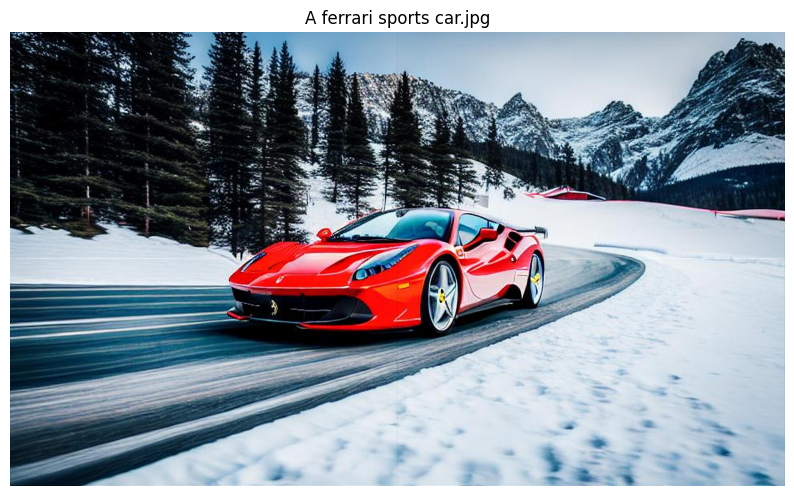

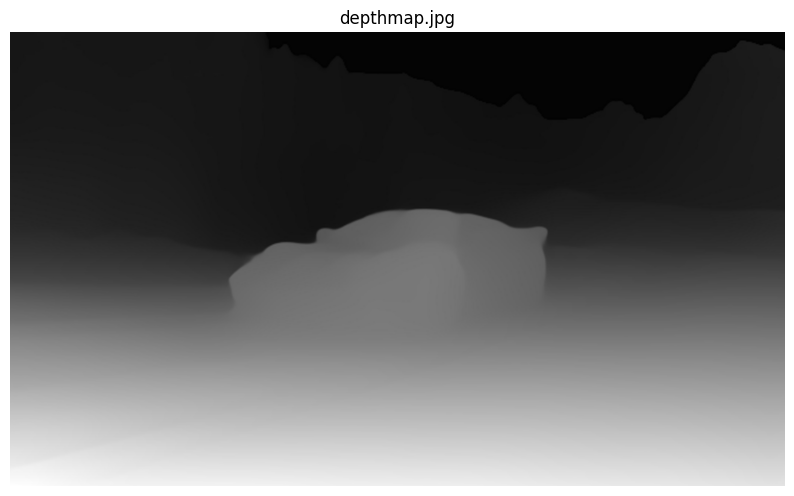

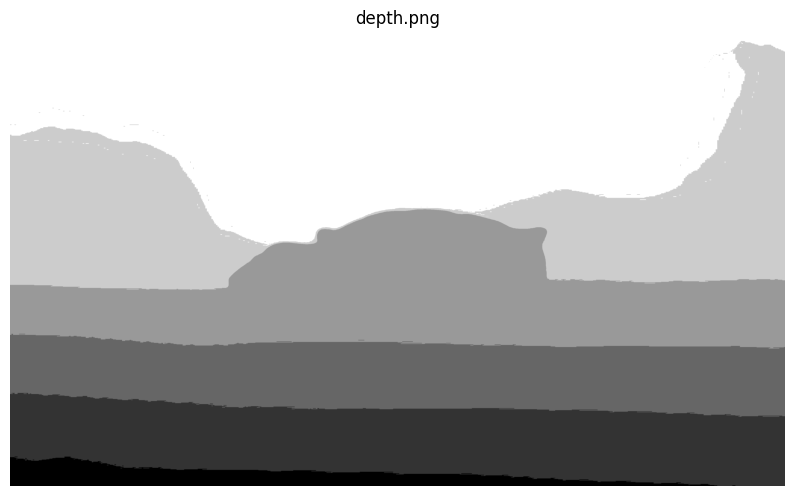

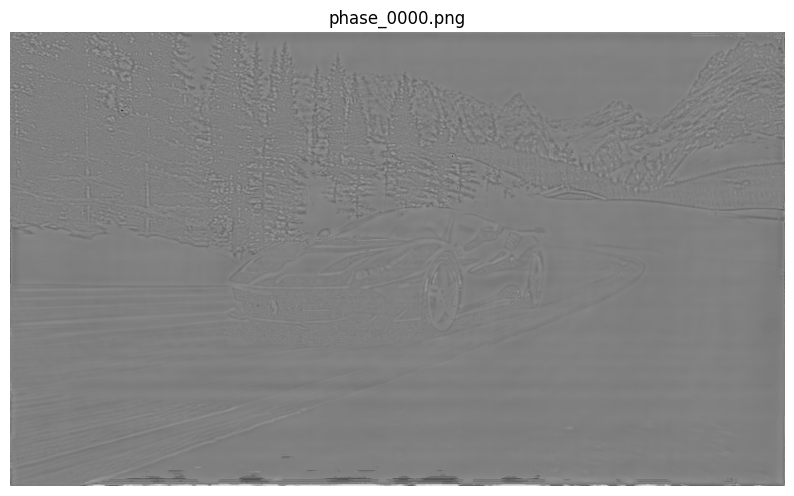

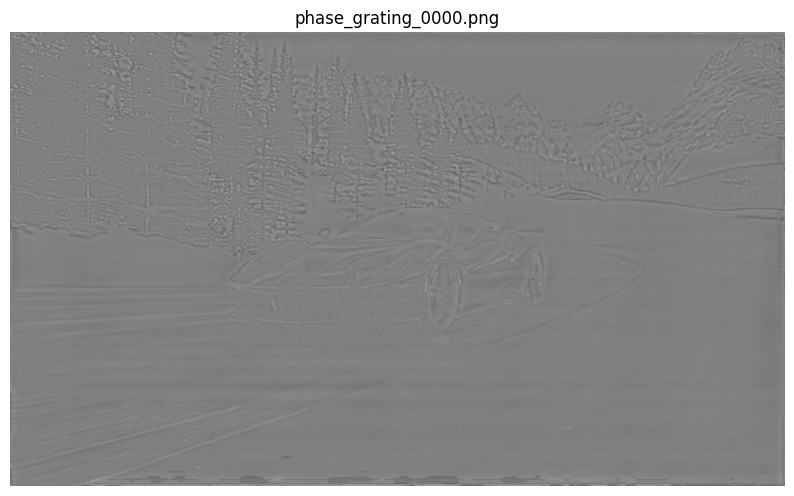

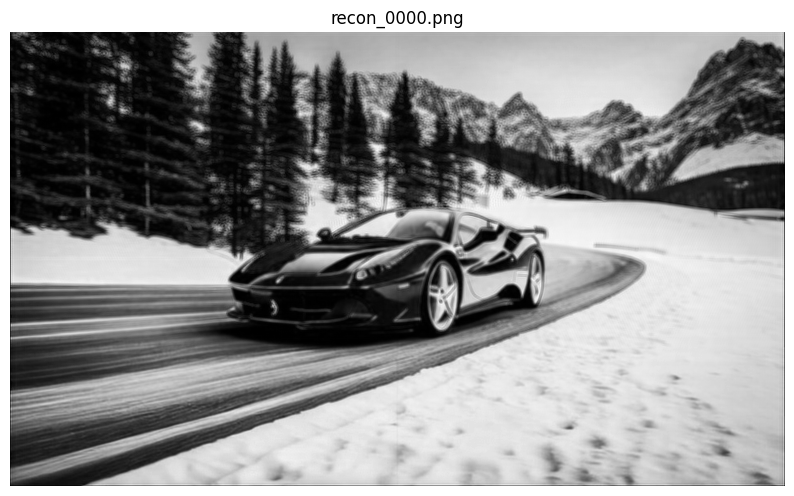

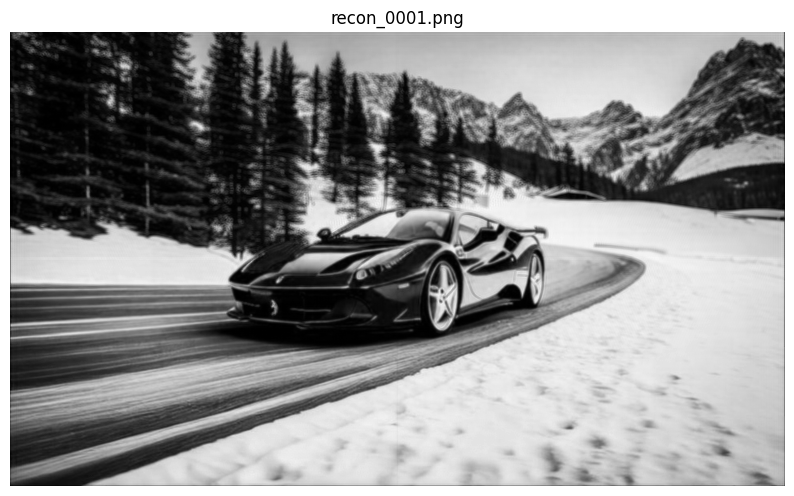

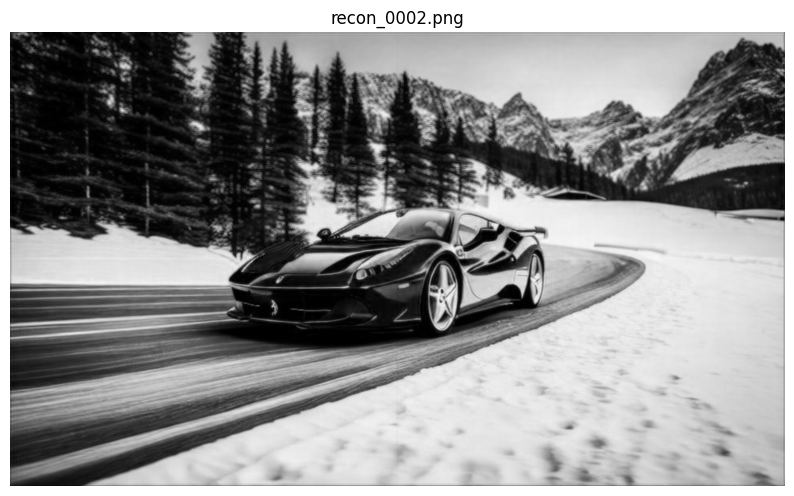

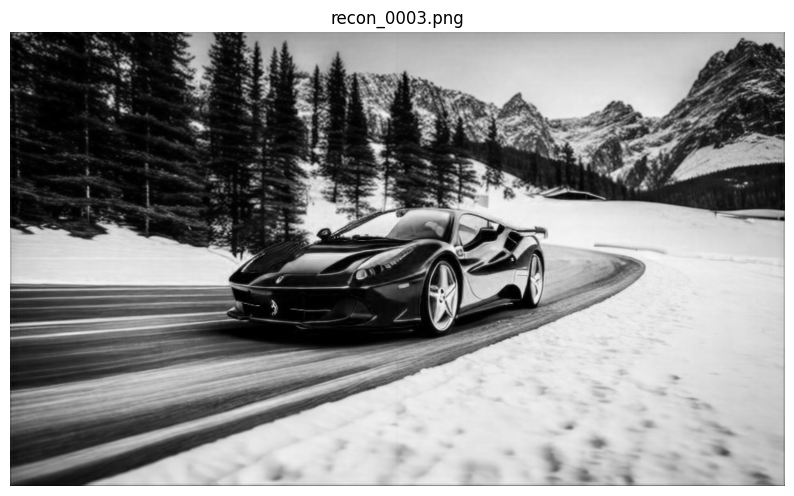

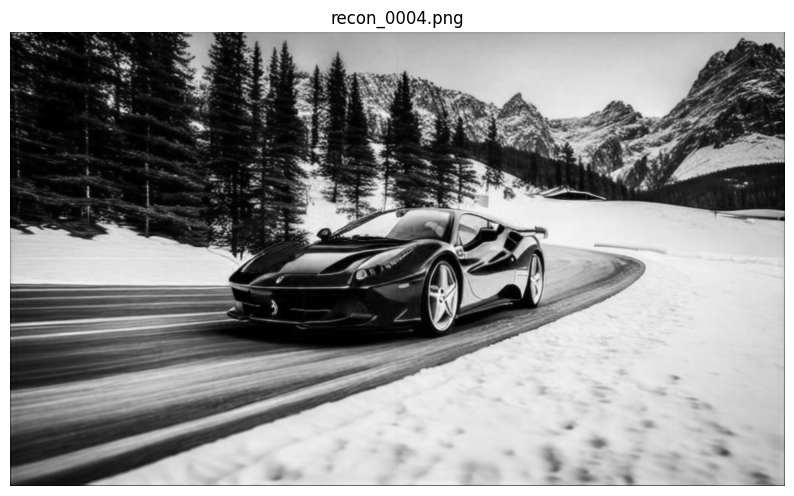

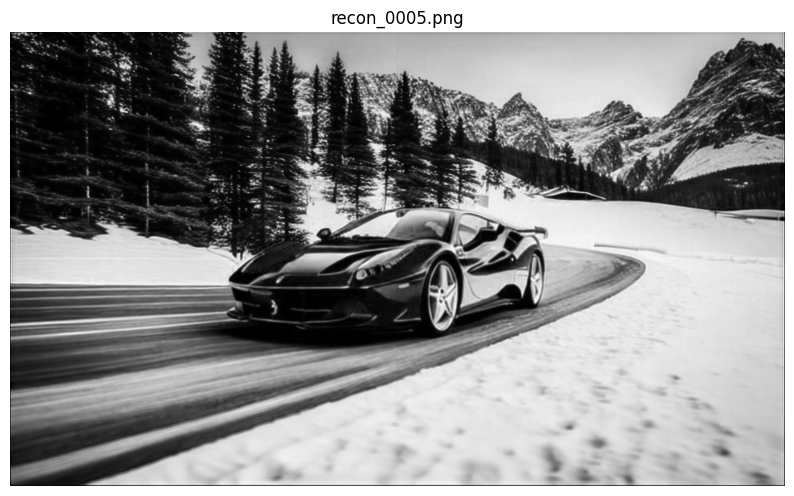

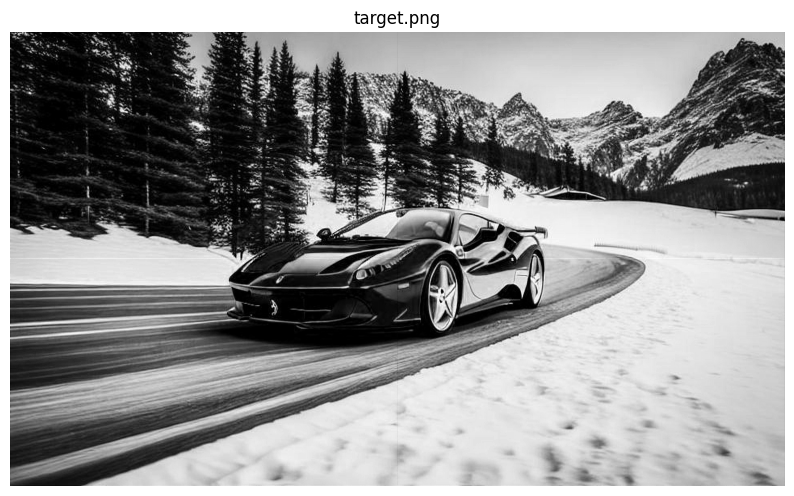

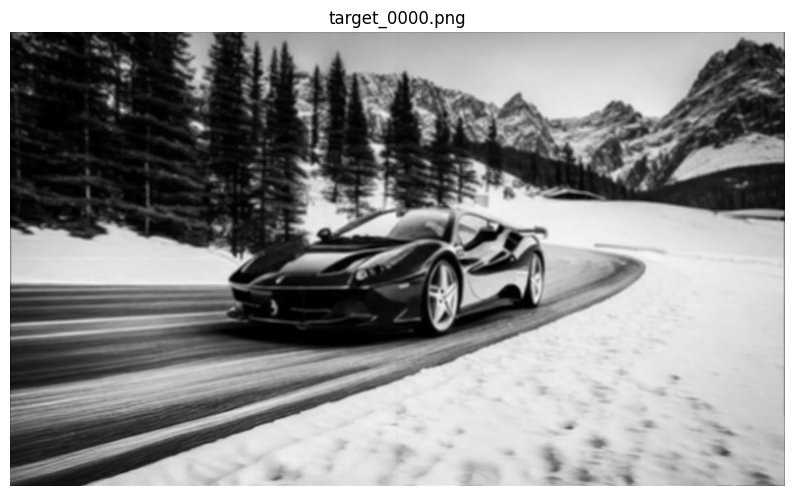

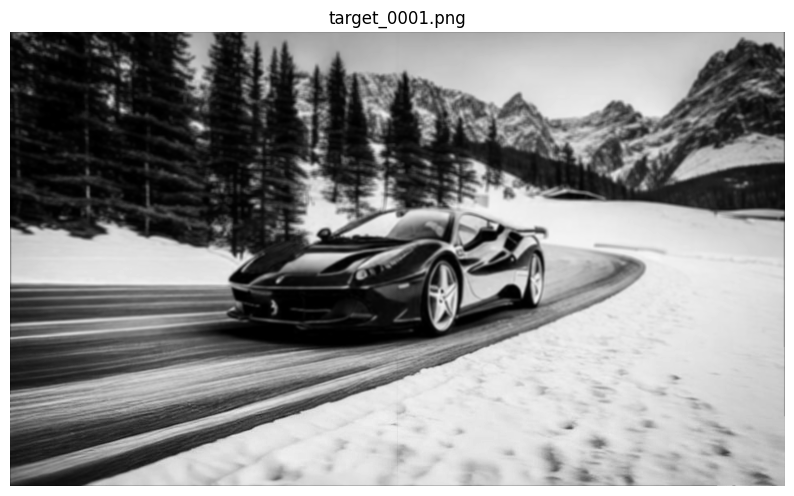

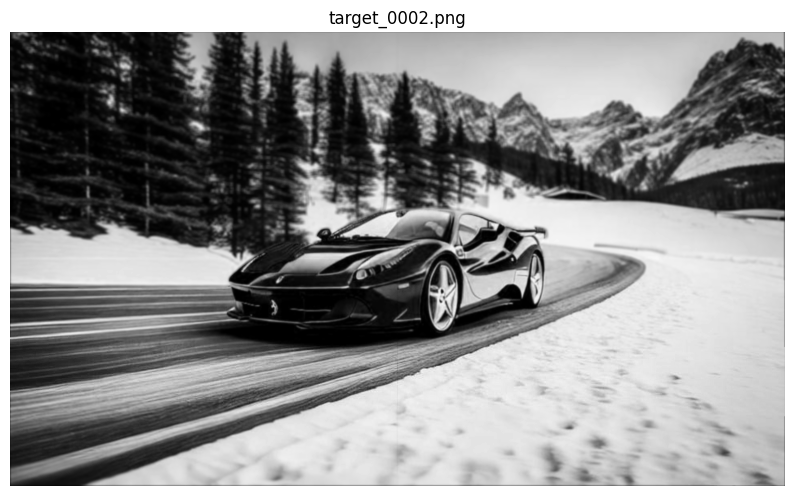

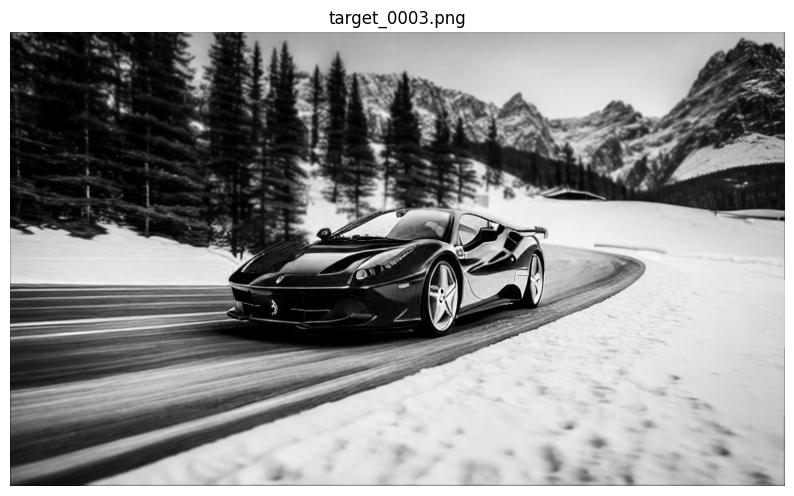

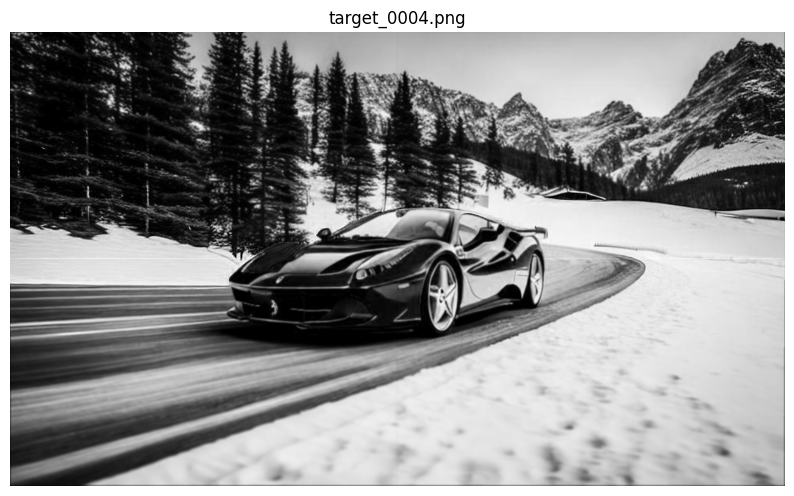

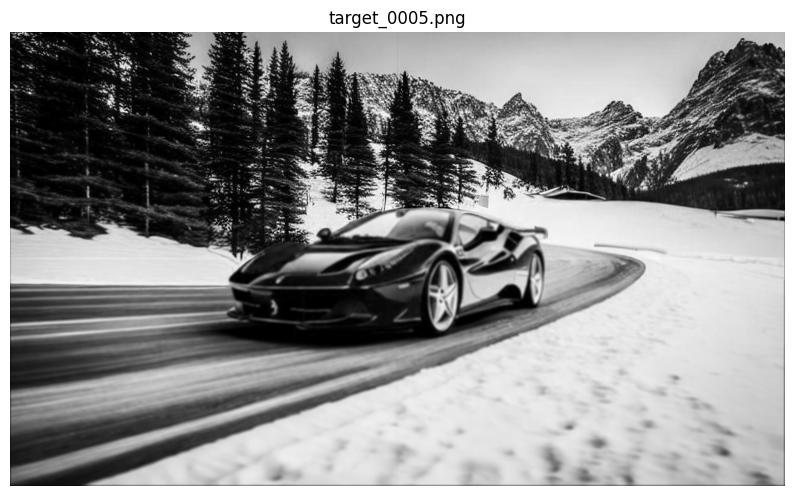

In [2]:
#@title # Text2hologram


# Get user input for the sentence to base the image creation on
prompt = "A ferrari sports car running on snowy mountain." #@param {type:"string"}
inference_steps = 40 # @param {type:"integer"}
# image_width = [600,1000] # @param ["[600,1000]", "[720,1200]", "[1200,2000]"] {type:"raw"}
output_directory = "CGH_output/" # @param {type:"string"}

settings = {

    "general": {
        "device": "cuda",
        "iterations": 200,
        "propagation type": "Bandlimited Angular Spectrum",
        "output directory": output_directory,
        "learning rate": 0.04,
        "hologram number": 1
    },
    "diffusion": {
        "inference_steps": 40,
        "resolution": [544, 960],
        "super_reso":'true'
    },
    "target": {
        "depth filename": "depthmap.jpg",
        "scheme": "defocus",
        "color channel": 1,
        "defocus blur size": 20,
        "blur ratio": 3,
        "number of planes": 6,
        "mask limits": [0.0, 1.0, 0.0, 1.0],
        "multiplier": 1.0,
        "weights": [1.0, 1.0, 1.0, 0.0]
    },
    "image": {
        "location": 0.0,
        "delta": 0.001,
        "zero mode distance": 0.15
    },
    "slm": {
        "model": "Jasper Display Educational 4k",
        "pixel pitch": 0.00000374,
        "resolution": [2400,4094]
    },
    "beam": {
        "wavelength": 0.000000518
    }
}


# Generate images
image_name, images = generate_images(pipe, prompt, settings, device)

if settings['diffusion']['super_reso']:
    print("Super-resolution is applied to create 4K images, requiring more memory. If crashing, use --super_reso=false to disable.")
    image_sr = super_resolve_image(image_name)
    settings['slm']['resolution'] = [2400,4094]

else:

    print("Super-resolution is off. Use --super_reso=true for 4K images. For memory issues, try on Colab:https://github.com/Linsonng/text2hologram/tree/main")
    image_sr = images[0]
    settings['slm']['resolution'] =  settings['diffusion']['resolution']
# Process the depth map
process_depth_map(midas, transform, np.array(image_sr), device, settings)

# Perform CGH
cgh(settings, image_name)


display_images_from_directory('./'+output_directory)
display_images_from_directory('./'+output_directory,ext='.png')